# Notebook 03c | Modelagem Prophet

Objetivos:

- Aplicar modelo Prophet em série mensal agregada de vendas  
- Utilizar as mesmas janelas de treino e teste:  
  1. Treino: 2016–2018 | Teste: 2019  
  2. Treino: 2016–2019 | Teste: 2020–2021  
- Avaliar desempenho das previsões (MAE, RMSE, R²)  

## 1. Configuração do Ambiente

Inicializar Spark, importar bibliotecas e definir caminho dos dados Gold mensais.

In [0]:
# Instalar prophet
%pip install scikit-learn prophet

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# Funções de métricas de avaliação
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res/ss_tot if ss_tot != 0 else np.nan

# Inicializar Spark
spark = SparkSession.builder.getOrCreate()

# Caminho da camada Gold mensal no DBFS
gold_monthly_path = "/FileStore/gold/sales_monthly_gold"


## 2. Leitura e Preparação dos Dados

Carregar o Parquet via Spark, converter para pandas e renomear colunas para Prophet.


In [0]:
# Carregar dados Gold mensal
df_spark = (
    spark.read
         .format("parquet")
         .load(gold_monthly_path)
         .withColumn("month_start", to_date("month_start"))
)

# Converter para pandas e garantir datetime
df = df_spark.toPandas()
df['ds'] = pd.to_datetime(df['month_start'])
df['y']  = df['total_sales_usd'].astype(float)

# Manter apenas colunas necessárias e ordenar
df = df[['ds', 'y']].sort_values('ds').reset_index(drop=True)


## 3. Janela 1: Treino 2016–2018, Teste 2019

Ajustar e prever com Prophet para o ano de 2019.


In [0]:
# Definir conjuntos de treino e teste
train1 = df[df['ds'] < '2019-01-01']
test1  = df[(df['ds'] >= '2019-01-01') & (df['ds'] < '2020-01-01')]

# Ajustar modelo Prophet e gerar previsões
model1 = Prophet(yearly_seasonality=True)
model1.fit(train1)

future1  = pd.DataFrame({'ds': test1['ds']})
forecast1 = model1.predict(future1)
pred1    = forecast1.set_index('ds')['yhat'].reindex(test1['ds'])

# Avaliar desempenho
print("Desempenho Prophet — Janela 1 (2019):")
print(f"MAE:  {mae(test1['y'].values, pred1.values):.2f}")
print(f"RMSE: {rmse(test1['y'].values, pred1.values):.2f}")
print(f"R2:   {r2(test1['y'].values, pred1.values):.4f}")


20:22:19 - cmdstanpy - INFO - Chain [1] start processing
20:22:20 - cmdstanpy - INFO - Chain [1] done processing


Desempenho Prophet — Janela 1 (2019):
MAE:  278990.11
RMSE: 298544.66
R2:   0.7200


## 4. Janela 2: Treino 2016–2019, Teste 2020–2021

Ajustar e prever com Prophet para o período da pandemia.


In [0]:
# Definir conjuntos de treino e teste
train2 = df[df['ds'] < '2020-01-01']
test2  = df[df['ds'] >= '2020-01-01']

# Ajustar modelo Prophet e gerar previsões
model2 = Prophet(yearly_seasonality=True)
model2.fit(train2)

future2  = pd.DataFrame({'ds': test2['ds']})
forecast2 = model2.predict(future2)
pred2    = forecast2.set_index('ds')['yhat'].reindex(test2['ds'])

# Avaliar desempenho
print("\nDesempenho Prophet — Janela 2 (2020–2021):")
print(f"MAE:  {mae(test2['y'].values, pred2.values):.2f}")
print(f"RMSE: {rmse(test2['y'].values, pred2.values):.2f}")
print(f"R2:   {r2(test2['y'].values, pred2.values):.4f}")


20:22:20 - cmdstanpy - INFO - Chain [1] start processing
20:22:20 - cmdstanpy - INFO - Chain [1] done processing



Desempenho Prophet — Janela 2 (2020–2021):
MAE:  1386391.60
RMSE: 1528987.28
R2:   -5.3870


## 5. Gráficos das Previsões vs Real

Visualizar as previsões comparadas aos valores reais para ambas as janelas.


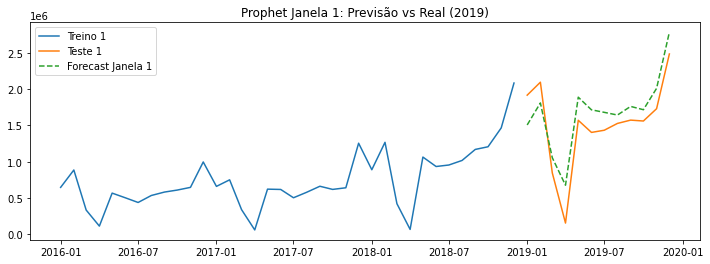

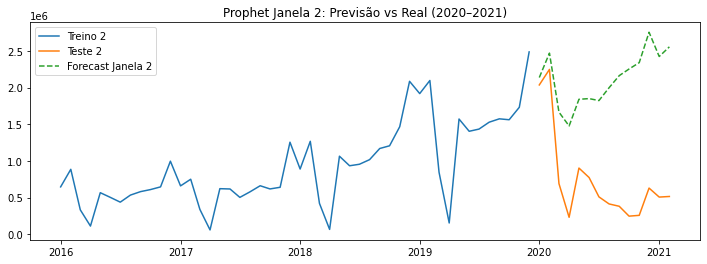

In [0]:
# Plot Janela 1
plt.figure(figsize=(12,4))
plt.plot(train1['ds'], train1['y'], label='Treino 1')
plt.plot(test1['ds'], test1['y'], label='Teste 1')
plt.plot(test1['ds'], pred1.values, '--', label='Forecast Janela 1')
plt.title('Prophet Janela 1: Previsão vs Real (2019)')
plt.legend()
plt.show()

# Plot Janela 2
plt.figure(figsize=(12,4))
plt.plot(train2['ds'], train2['y'], label='Treino 2')
plt.plot(test2['ds'], test2['y'], label='Teste 2')
plt.plot(test2['ds'], pred2.values, '--', label='Forecast Janela 2')
plt.title('Prophet Janela 2: Previsão vs Real (2020–2021)')
plt.legend()
plt.show()


## 6. Conclusões

- **Janela 1 (2019):**  
  - MAE ≈ 278 990, RMSE ≈ 298 545 e R² = 0,720  
  - Indica ajuste forte à tendência e sazonalidade pré-pandemia.  
  - Desempenho superior ao SARIMA (MAE/RMSE menores e R² mais alto).

- **Janela 2 (2020–2021):**  
  - MAE ≈ 1 386 392, RMSE ≈ 1 528 987 e R² = –5,387  
  - O Prophet também apresentou falha em capturar o choque da pandemia, gerando previsões piores que a média.  
  - Desempenho ainda mais degradado que o SARIMA no mesmo período.

- **Comparação geral:**  
  - Antes da pandemia, Prophet supera SARIMA na captura de sazonalidade anual.  
  - Em cenários de ruptura estrutural (pandemia), ambos os modelos sem regressores externos apresentam desempenho muito ruim.  
  - SARIMA apresentou R² ≈ –0,536 versus Prophet com R² ≈ –5,387, indicando que Prophet se desviou ainda mais dos valores reais durante o choque.

## 7. Encerramento do Projeto

O modelo Prophet apresentou desempenho satisfatório na previsão da série temporal mensal de vendas no período pré-pandemia, sendo superior ao SARIMA em termos de erro absoluto, erro quadrático médio e capacidade explicativa. Apesar da limitação observada durante o período pandêmico, a abordagem adotada cumpre os objetivos definidos para este projeto.

Como possíveis extensões futuras, considera-se:

- Inclusão de regressores exógenos, como feriados, indicadores econômicos e variáveis dummy para eventos extraordinários;  
- Teste de modelos alternativos ou híbridos que considerem mudança de regime;  
- Avaliação de estratégias mais robustas de validação, como Validação Cruzada com Janela Rolante.

Com isso, conclui-se esta fase do projeto de modelagem preditiva com Prophet.
